# Building a Time Series Model for Nifty Prices

## Notebook Overview

This document serves as a guide to developing a robust time series model for forecasting Nifty prices. It is designed to walk you through each step, from data collection to performance evaluation, integrating theoretical knowledge with practical application.

### 1. [**Reading Price Data**]()
   - **Data Acquisition**: Fetch Nifty price data using the `yfinance` API, renowned for its accessibility and reliability.
   - **Resampling**: Obtain weekly frequency data to focus on longer-term trends and reduce noise.
   
### 2. [**Data Sanity Check**]()
   - **Quality Assessment**: Perform checks for missing values and outliers to ensure data integrity.
   - **Data Cleaning**: Implement strategies to handle anomalies, such as interpolation for missing values or removal of erroneous data points, ensuring robustness in the modeling process.

### 3. [**Selecting the Right Model and Forecasting Prices**]()
   - **Preliminary Analysis**: Examine the stationarity of the time series, applying differencing if necessary to meet model assumptions.
   - **Model Determination**:
     - Assess the Autoregressive (AR) order to gauge the influence of past values on current predictions.
     - Evaluate the Moving Average (MA) order to understand the impact of past forecast errors on future values.
   - **Model Selection**: Use the Akaike Information Criterion (AIC) to identify the most efficient model in terms of informational balance and complexity.
   - **Implementation**: Develop a function for model selection and forecasting, employing a sliding window technique to update predictions dynamically.

### 4. [**Trading Strategy Using Predicted Prices**]()
   - **Strategy Design**: Formulate a trading strategy based on model predictions, detailing specific buy and sell signals.
   - **Execution Plan**: Outline the operational aspects of executing trades based on predictive insights, considering transaction costs and timing.

### 5. [**Performance Analysis**]()
   - **Model Evaluation**: Analyze the accuracy of the model's predictions by comparing them against actual market movements.
   - **Strategy Testing**: Assess the strategy's performance using backtesting, comparing it against a benchmark 'buy and hold' strategy to evaluate relative effectiveness.

## Summary

This notebook is structured to facilitate a deep understanding of time series analysis applied to financial markets, with a specific focus on Nifty prices. By the end, you should be able to not only develop and test a forecasting model but also understand how to translate these forecasts into actionable trading strategies.



## Import modules

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append("..")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# For data manipulation
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# For statistical analysis
from statsmodels.tsa.arima.model import ARIMA

#for price data
import yfinance as yf
import pandas_datareader.data as web

<a id='Read_price_data'></a>
## Read price data

In [3]:
# Define the symbol, start, and end dates for the Nifty index
symbol = '^NSEI'
start = '2019-01-01'
end = '2023-12-31'

# Download weekly closing price data for Nifty from Yahoo Finance
data = yf.download(symbol, start=start, end=end, interval='1d')[['Adj Close']]
# Display the first few rows of the data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2019-01-02,10792.500000
2019-01-03,10672.250000
2019-01-04,10727.349609
2019-01-07,10771.799805
2019-01-08,10802.150391



## Data Sanity Check

In this section, we define a method to ensure the integrity of our dataset before proceeding with further analysis. This method will address key aspects:

- **Missing Values**: Identification and imputation of missing data points using forward-fill to preserve continuity in time series data.
- **Outliers**: Detection and examination of extreme values based on statistical thresholds to prevent skewed analysis. Outliers will be assessed against a rolling median over a 52-week period to determine their significance.
- **Data Continuity**: Visual and statistical checks for discontinuities or abrupt changes in the data that could indicate recording errors or genuine market anomalies.

This proactive approach helps ensure that our model's inputs are reliable and that the ensuing analysis is robust.

In [4]:
import pandas as pd

def sanity_check(data):
    """
    Check for and handle data issues such as missing values and extreme outliers.

    Parameters:
    - data (DataFrame): The DataFrame containing the 'Adj Close' prices of the Nifty index.

    Returns:
    - DataFrame: The cleaned and potentially modified DataFrame.
    """
    # Check for missing values
    if data.isnull().values.any():
        print("Missing values found.")
        # Filling missing values with the previous day's prices (forward fill)
        data.fillna(method='ffill', inplace=True)
        print("Missing values have been forward-filled.")
    else:
        print("No missing values in the data.")

    return data

In [5]:
data = sanity_check(data)

No missing values in the data.


In [6]:
# Check for invalid/NaN data
print(data.isnull().sum())

Adj Close    0
dtype: int64


This data has no NaN values.


### Checking for Stationarity
- **ADF Test**: We employ the Augmented Dickey-Fuller (ADF) test, a popular statistical test used to check for stationarity. The test aims to determine whether a unit root is present in the series, which is indicative of non-stationarity.
- **Interpretation**: If the ADF test shows that the data does not contain a unit root, the series can be considered stationary, and models like ARMA (Autoregressive Moving Average) are suitable.
- **Differencing**: If the test indicates non-stationarity, we proceed by differencing the data. This involves subtracting the previous observation from the current observation. We then reapply the ADF test to the differenced data to check for stationarity again.
- **Model Application**: If the differenced data is stationary, we use an ARIMA (Autoregressive Integrated Moving Average) model, which integrates the differencing step into the modeling process.

This approach ensures that the time series model is built on a solid foundation of data that meets the necessary statistical properties, enhancing the reliability and accuracy of the forecasts.

In [7]:
def check_stationarity(df):
    adf_result = adfuller(df)

    if(adf_result[1] < 0.05):
        print('Data is stationary')
    else:
        print('Data is not stationary')

In [8]:
# Checking the Adj Close for stationarity
check_stationarity(data['Adj Close'])

Data is not stationary


The asset is not stationary. This means we can not use the ARMA model. Next, we will check whether we can apply the ARIMA model.

In [9]:
# Check the differenced asset 1 for stationarity
check_stationarity(data['Adj Close'].diff().dropna())

Data is stationary




### Understanding ACF and PACF Plots

In the process of building ARIMA models for time series forecasting, the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) are crucial tools for identifying the order of the AR (AutoRegressive) and MA (Moving Average) components.

#### Autocorrelation Function (ACF)
- **What is ACF?** The ACF measures the correlation between time series observations at different lags. In simpler terms, it expresses how well the current value of the series is related to its past values.
- **Significance:** ACF is used to identify the moving average component of an ARIMA model, denoted as \(q\). It shows the extent of correlation between a variable and its lag across successive time intervals. If the ACF shows a gradual decline, it suggests a moving average process might be suitable.

#### Partial Autocorrelation Function (PACF)
- **What is PACF?** The PACF measures the correlation between observations at two points in time, controlling for the values at all shorter lags. It isolates the effect of intervening time points.
- **Significance:** PACF is primarily used to determine the order of the autoregressive component of an ARIMA model, denoted as \(p\). A sharp cut-off in the PACF after a certain number of lags suggests the order of the AR process.

#### Application in Time Series Analysis
- **Differencing:** Before plotting ACF and PACF, the series should be made stationary. This often involves differencing the series, where each value is subtracted from its previous value, to remove trends and seasonality.
- **Model Identification:** By examining the patterns in the ACF and PACF plots, you can make informed decisions about the likely parameters for the ARIMA model. For example, if the PACF plot shows a significant spike at lag 2, followed by non-significant spikes, this suggests an AR(2) model might be appropriate.

These plots provide a visual insight into the data which can guide the specification of your time series model, improving the model's accuracy and predictive power.


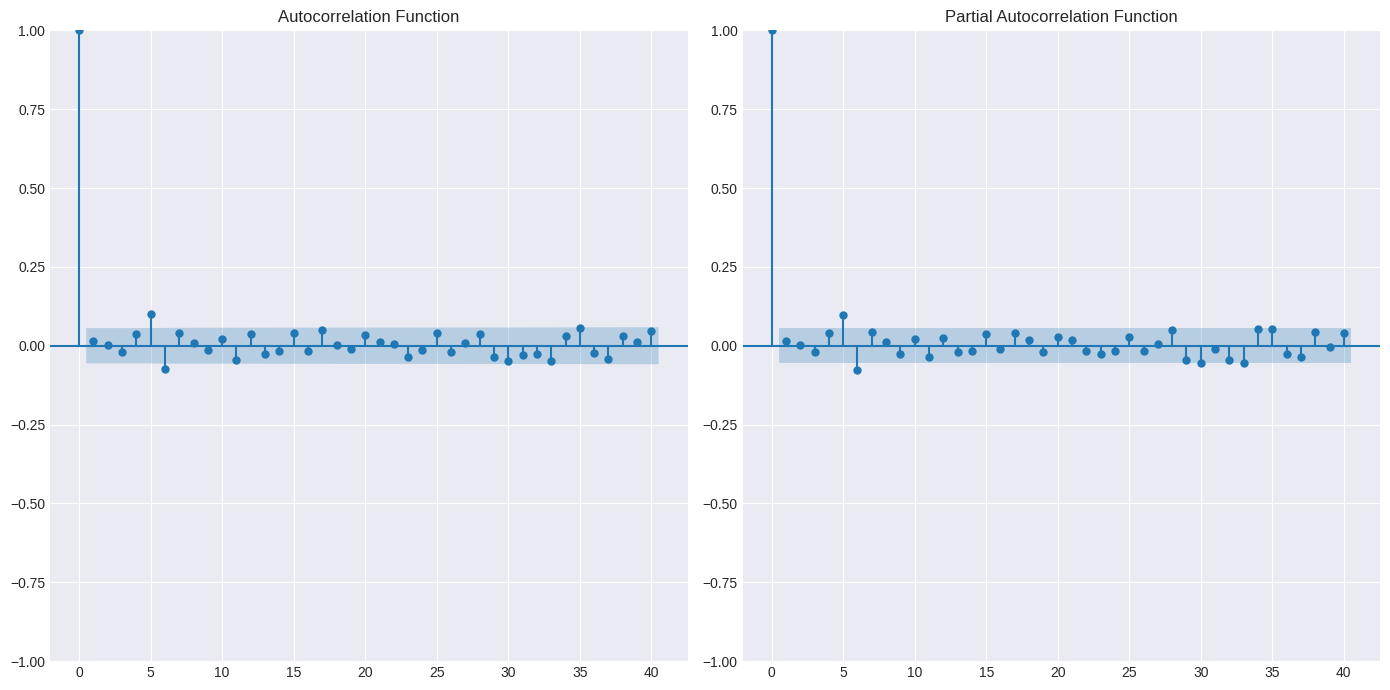

In [10]:
#Importing neccessary module from statsmodels library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#To accurately map the acf and pacf, we need a stationary series
diff_data = data['Adj Close'].diff().dropna()

# Plotting ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)  # 1 row, 2 columns, 1st subplot
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

# Plotting PACF
plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

The data is stationary after differencing. This means we can use the ARIMA model. Let us now find the p,q, and d order of the ARIMA model.

We can compare the AIC score of the models with different p,q and d values. The best fit model would be the one with the lowest AIC score.

### Modeling time series using ARIMA models

The **ARIMA (AutoRegressive Integrated Moving Average)** class of models is a popular statistical technique in time series forecasting. It exploits different standard temporal structures seen in time series processes.

> *Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.*

##### ***Overview on ARIMA***
We will now take a brief look at its key features by taking apart the acronym.

1. **Auto Regressive (AR)**:

- Regression of a time series process onto itself (its past versions)
- A time series process is $AR$ if its present value depends on a linear combination of past observations.
- In financial time series, an $AR$ model attempts to explain the mean reversion and trending behaviours that we observe in asset prices.

2. **Integrated (I)**:

For a time series process ${X_t}$ recorded at regular intervals, the difference operation is defined as $$\nabla X_t = X_t - X_{t-1}$$

The difference operator (denoted by $\nabla$) can be applied repeatedly. For example,
$$\nabla^2 X_t = \nabla X_t - \nabla X_{t-1}$$

- A time series process is integrated of order $d$ (denoted by $I(d)$), if differencing the observations $d$ times, makes the process stationary.

3. **Moving Average (MA)**:

-  A time series process is $MA$ if its present value can be written as a linear combination of past error terms.
- $MA$ models try to capture the idiosyncratic shocks observed in financial markets. We can think of events like terrorist attacks, earnings surprises, sudden political changes, etc. as the random shocks affecting the asset price movements.

When we use the ARIMA class to model a time series process, each of the above components are specified in the model as parameters (with the notations $p$, $d$, and $q$ respectively).

That is, the classification $ARIMA(p, d, q)$ process can be thought of as $$AR(p)I(d)MA(q)$$
Here,

1. $p$: The number of past observations (we usually call them *lagged terms*) of the process included in the model.
2. $d$: The number of times we difference the original process to make it stationary.
3. $q$: The number of past error terms (we usually call them *lagged error terms* or *lagged residuals*) of the process included in the model.

When we model our time series process with the ARIMA class, we implicitly assume that the underlying data generating process (and by extension the observations we record) is an ARIMA process.

We should validate our assumptions (especially the implicit ones which slip under the radar) and recognize the limitations of our models. A well-known deficiency of ARIMA applications on financial time series is its failure to capture the phenomenon of volatility clustering. However, despite their inaccurate point estimates, they give rise to informative confidence intervals.

 **All of the below models would have good explanatory and predictive power only if the process is stationary.**

$$AR(1) : X_t = \phi X_{t-1} + \epsilon_t$$
$$MA(1) : X_t = \epsilon_t + \theta \epsilon_{t-1}$$

$$AR(p) : X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t$$
$$MA(q) : X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

$$ARMA(p, q) : X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

In [11]:
#splitting the data into train and test that we can use the test data to evaluate our chosen model
split = int(len(data)*0.8)
data_train = data[:split]
data_test = data[split:]

data_train.shape[0], data_test.shape[0]

(985, 247)

In [12]:
data_test.tail()

,Adj Close
Date,
2023-12-22,21349.400391
2023-12-26,21441.349609
2023-12-27,21654.750000
2023-12-28,21778.699219
2023-12-29,21731.400391


In [13]:
import warnings
import pmdarima as pm

def find_best_arima_parameters(data_series, seasonal=False, m=1):
    """
    Finds the best ARIMA parameters for the given time series data using auto_arima from pmdarima.

    Parameters:
    - data_series (pd.Series): Pandas Series containing the time series data.
    - seasonal (bool): Whether to consider seasonal differencing.
    - m (int): The number of periods in each season (relevant if seasonal is True).

    Returns:
    - tuple: The best (p, d, q) parameters for the ARIMA model.
    """
    # Ignoring warnings
    warnings.filterwarnings('ignore')

    # Performing the auto ARIMA process
    model = pm.auto_arima(data_series, seasonal=seasonal, m=m,
                          trace=True, error_action='ignore', suppress_warnings=True)

    # Extracting the best ARIMA order
    best_order = model.order  # This gives (p, d, q)

    # Optionally, print the summary of the best model
    print(model.summary())

    return best_order

# Assuming 'data' is your DataFrame and 'Adj Close' is a column in that DataFrame
best_param = find_best_arima_parameters(data_train['Adj Close'])
print("Best ARIMA parameters (p, d, q):", best_param)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12798.213, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12805.026, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12806.984, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12806.989, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12805.113, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12810.971, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12810.981, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12798.938, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12799.055, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12808.989, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12812.291, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12812.400, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12802.674, Time=1.17 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12811.477, Time=0.32 sec

Best model:  ARIMA

We find that ARIMA(2,1,2) is the best model

# Forecast Prices

We will now create a function to apply the ARIMA model with the selected parameters on the close price data.

In [14]:
def get_predicted_prices(close_prices, best_param):

    # Defining the best model
    best_model = ARIMA(close_prices.values, order=best_param)
    best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})

    # Making forecast
    predictions = best_model_fit.forecast(steps=1)[0]
    return predictions

In [15]:
data_test

,Adj Close
Date,
2022-12-29,18191.000000
2022-12-30,18105.300781
2023-01-02,18197.449219
2023-01-03,18232.550781
2023-01-04,18042.949219
...,...
2023-12-22,21349.400391
2023-12-26,21441.349609
2023-12-27,21654.750000


In [16]:
# Assuming best_param has already been determined using the training data
predictions = []
for i in range(len(data_test['Adj Close'])):
    # Incrementally adding test data to simulate a rolling forecast
    current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
    next_pred = get_predicted_prices(current_data, best_param)
    predictions.append(next_pred)

# Converting the predictions list to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
predictions_df.index = data_test.index

predictions_df

,predicted_price
Date,
2022-12-29,18124.805379
2022-12-30,18190.704801
2023-01-02,18105.668161
2023-01-03,18197.011369
2023-01-04,18232.363400
...,...
2023-12-22,21254.774560
2023-12-26,21357.397053
2023-12-27,21443.287619


In [17]:
#concatenating the predictions_df with data_test
data_test = pd.concat([data_test, predictions_df], axis=1)
data_test

,Adj Close,predicted_price
Date,,
2022-12-29,18191.000000,18124.805379
2022-12-30,18105.300781,18190.704801
2023-01-02,18197.449219,18105.668161
2023-01-03,18232.550781,18197.011369
2023-01-04,18042.949219,18232.363400
...,...,...
2023-12-22,21349.400391,21254.774560
2023-12-26,21441.349609,21357.397053
2023-12-27,21654.750000,21443.287619


In [18]:
data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
data_test['actual_returns'] = data_test['Adj Close'].pct_change()

data_test.dropna(inplace=True)

data_test

,Adj Close,predicted_price,predicted_returns,actual_returns
Date,,,,
2022-12-30,18105.300781,18190.704801,0.003636,-0.004711
2023-01-02,18197.449219,18105.668161,-0.004675,0.005090
2023-01-03,18232.550781,18197.011369,0.005045,0.001929
2023-01-04,18042.949219,18232.363400,0.001943,-0.010399
2023-01-05,17992.150391,18037.771994,-0.010673,-0.002815
...,...,...,...,...
2023-12-22,21349.400391,21254.774560,0.005168,0.004439
2023-12-26,21441.349609,21357.397053,0.004828,0.004307
2023-12-27,21654.750000,21443.287619,0.004022,0.009953


In [19]:
#signal generation
data_test['signal'] = np.where(data_test['predicted_returns'] >=0, 1, -1)

#we may approach differently here and assume that we have learnt the predicted prices in advance and will be able to position ourselves
data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns']+1)
data_test

,Adj Close,predicted_price,predicted_returns,actual_returns,signal,strategy_returns,cumulative_returns
Date,,,,,,,
2022-12-30,18105.300781,18190.704801,0.003636,-0.004711,1,-0.004711,0.995289
2023-01-02,18197.449219,18105.668161,-0.004675,0.005090,-1,-0.005090,0.990223
2023-01-03,18232.550781,18197.011369,0.005045,0.001929,1,0.001929,0.992133
2023-01-04,18042.949219,18232.363400,0.001943,-0.010399,1,-0.010399,0.981816
2023-01-05,17992.150391,18037.771994,-0.010673,-0.002815,-1,0.002815,0.984580
...,...,...,...,...,...,...,...
2023-12-22,21349.400391,21254.774560,0.005168,0.004439,1,0.004439,1.198199
2023-12-26,21441.349609,21357.397053,0.004828,0.004307,1,0.004307,1.203359
2023-12-27,21654.750000,21443.287619,0.004022,0.009953,1,0.009953,1.215336


In [20]:
#buy and hold returns
buy_and_hold_returns = (1+data_test['actual_returns']).cumprod()
buy_and_hold_returns

Date
2022-12-30    0.995289
2023-01-02    1.000355
2023-01-03    1.002284
2023-01-04    0.991861
2023-01-05    0.989069
                ...   
2023-12-22    1.173624
2023-12-26    1.178679
2023-12-27    1.190410
2023-12-28    1.197224
2023-12-29    1.194624
Name: actual_returns, Length: 246, dtype: float64

### Plot the predicted and actual cumulative(buy and hold returns)


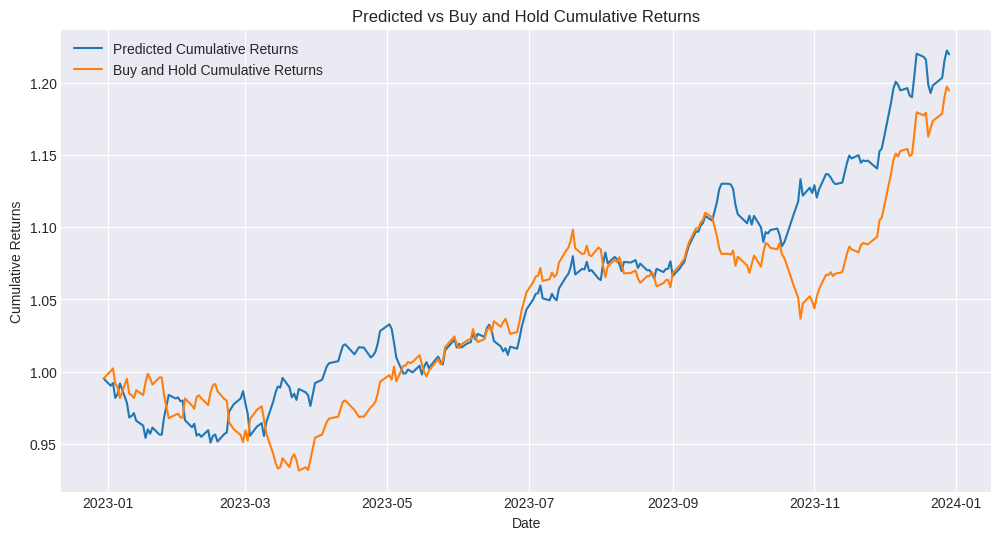

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Predicted vs Buy and Hold Cumulative Returns')
plt.legend()
plt.show()

WE CAN SEE HOW OUR STRATEGY OUTPERFORMED THE BUY AND HOLD RETURNS(MARKET RETURNS)

WE WILL COMPARE THE STRATGY ON TWO MORE METRICS
1. SHARPE_RATIO
2. DRAWDOWN

The maximum drawdown of the strategy is -4.91


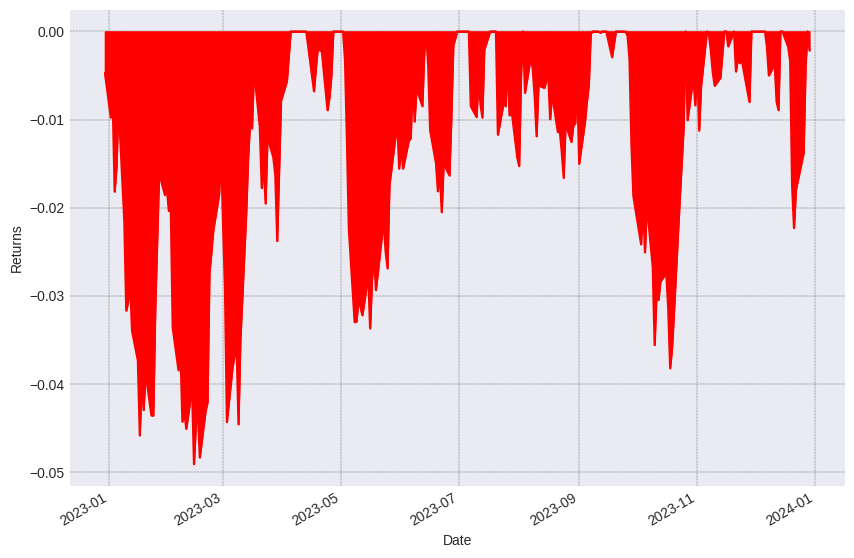

In [22]:
#DRAWDOWN ANALYSIS
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

drawdown_strategy = calc_drawdown(data_test['cumulative_returns'])
print("The maximum drawdown of the strategy is %.2f" % (drawdown_strategy.min()*100))
plot_drawdown(drawdown_strategy)

The maximum drawdown of the bnh strategy is -7.06


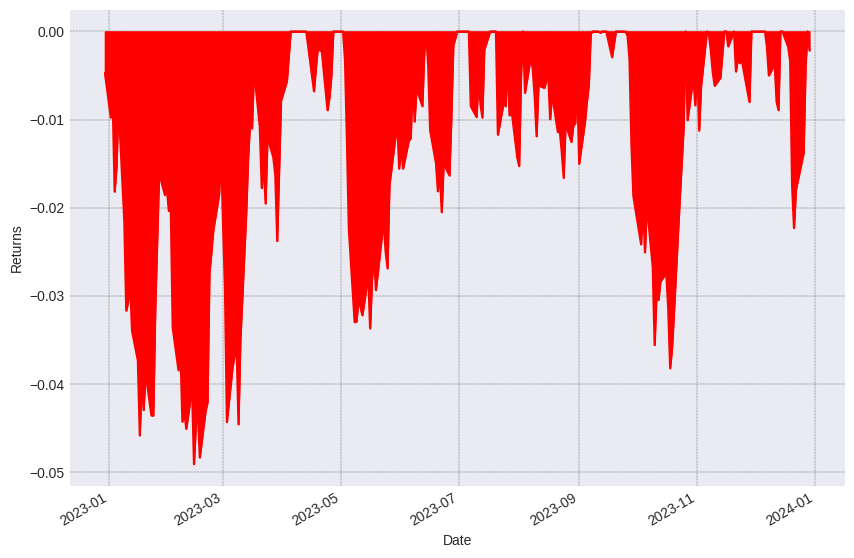

In [23]:
#buy and hold max drawdown

drawdown_buy_n_hold = calc_drawdown(buy_and_hold_returns)
print("The maximum drawdown of the bnh strategy is %.2f" % (drawdown_buy_n_hold.min()*100))
plot_drawdown(drawdown_strategy)

In [24]:
#let's check the sharpe ratio of the strategy
sharpe_ratio = (data_test['strategy_returns'].mean()*252)/(data_test['strategy_returns'].std()*np.sqrt(252))
print("The sharpe ratio of the strategy is %.2f" % sharpe_ratio)

The sharpe ratio of the strategy is 2.13
